### Working With STAC

Need to run at scale? checkout https://github.com/developmentseed/titiler/blob/master/Notebooks/WorkingWithSTAC.ipynb

###### Requirements

`pip install tdqm stac-tiler rio-color`

In [1]:
import os
import json
import base64
import requests
import datetime
import itertools
import urllib.parse

from io import BytesIO
from functools import partial
from concurrent import futures
from rasterio.plot import reshape_as_image

from rasterio.features import bounds as featureBounds

from rio_tiler_crs import STACReader

from rio_color.operations import parse_operations
from rio_color.utils import scale_dtype, to_math_type

from tqdm.notebook import tqdm

%pylab inline

# STAC API hosted by element84
stac_endpoint = "https://earth-search.aws.element84.com/v0/search"

Populating the interactive namespace from numpy and matplotlib


#### Define Area of Interest (AOI)

In [2]:
# use geojson.io
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              30.810813903808594,
              29.454247067148533
            ],
            [
              30.88600158691406,
              29.454247067148533
            ],
            [
              30.88600158691406,
              29.51879923863822
            ],
            [
              30.810813903808594,
              29.51879923863822
            ],
            [
              30.810813903808594,
              29.454247067148533
            ]
          ]
        ]
      }
    }
  ]
}

bounds = featureBounds(geojson)

## STAC Search

Use STAC API to search for data over our AOI

Doc: https://github.com/radiantearth/stac-api-spec

In [3]:
# Date filter
date_min="2019-01-01"
date_max="2019-12-11"

start = datetime.datetime.strptime(date_min, "%Y-%m-%d").strftime("%Y-%m-%dT00:00:00Z")
end = datetime.datetime.strptime(date_max, "%Y-%m-%d").strftime("%Y-%m-%dT23:59:59Z")

query = {
    "collections": ["sentinel-s2-l2a-cogs"], # Make sure to query only sentinel-2 COGs collection
    "datetime": f"{start}/{end}",
    "query": {
        "eo:cloud_cover": {
            "lt": 5
        }  # Use low cloud cover
    },
    "intersects": geojson["features"][0]["geometry"],
    "limit": 1000,
    "fields": {
      'include': ['id', 'properties.datetime', 'properties.eo:cloud_cover'],  # Make returned response ligth 
      'exclude': ['assets', 'links']
    }
}

headers = {
    "Content-Type": "application/json",
    "Accept-Encoding": "gzip",
    "Accept": "application/geo+json",
}


data = requests.post(stac_endpoint, headers=headers, json=query).json()
print(data["context"])
print()
print("Example:")
print(json.dumps(data["features"][0], indent=4))

sceneid = [f["id"] for f in data["features"]]
cloudcover = [f["properties"]["eo:cloud_cover"] for f in data["features"]]
dates = [f["properties"]["datetime"][0:10] for f in data["features"]]

{'page': 1, 'limit': 1000, 'matched': 78, 'returned': 78}

Example:
{
    "bbox": [
        30.155974613579858,
        28.80949327971016,
        31.050481437029678,
        29.815791988006527
    ],
    "geometry": {
        "coordinates": [
            [
                [
                    30.155974613579858,
                    28.80949327971016
                ],
                [
                    30.407037927198104,
                    29.805008695373978
                ],
                [
                    31.031551610920825,
                    29.815791988006527
                ],
                [
                    31.050481437029678,
                    28.825387639743422
                ],
                [
                    30.155974613579858,
                    28.80949327971016
                ]
            ]
        ],
        "type": "Polygon"
    },
    "id": "S2B_36RTT_20191205_0_L2A",
    "collection": "sentinel-s2-l2a-cogs",
    "type": "Feature",
    

#### Plot Cloud cover / dates

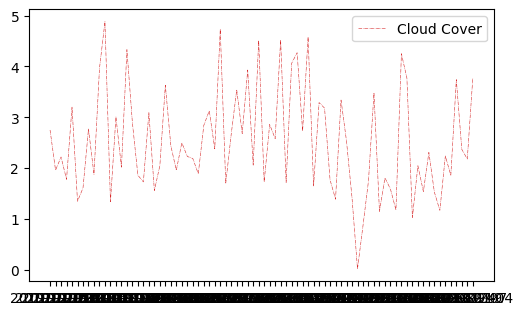

In [4]:
fig = plt.figure(dpi=100)
fig.autofmt_xdate()
ax = fig.add_subplot(1, 1, 1)
ax.plot(dates, cloudcover, label="Cloud Cover", color="tab:red", linewidth=0.4, linestyle="-.")

ax.legend()

### Read DATA

```
# TILE
with STACReader("stac.json") as stac:
    tile, mask = stac.tile(1, 2, 3, tilesize=256, assets=["red", "green"])

# With expression
with STACReader("stac.json") as stac:
    tile, mask = cog.tile(1, 2, 3, tilesize=256, expression="red/green")

# PART
with STACReader("stac.json") as stac:
    data, mask = stac.part((10, 10, 20, 20), assets=["red", "green"])

# Limit output size (default is set to 1024)
with STACReader("stac.json") as stac:
    data, mask = stac.part((10, 10, 20, 20), max_size=2000, assets=["red", "green"])

# Read high resolution
with STACReader("stac.json") as stac:
    data, mask = stac.part((10, 10, 20, 20), max_size=None, assets=["red", "green"])

# With expression
with STACReader("stac.json") as stac:
    data, mask = stac.part((10, 10, 20, 20), expression="red/green")

# POINT
with STACReader("stac.json") as stac:
    pts = stac.point(-100, 25, assets=["red", "green"])

# With expression
with STACReader("stac.json") as stac:
    pts = stac.point(-100, 25, expression="red/green")

```


In [5]:
url_template = "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/{id}"

### Visualize One Item

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


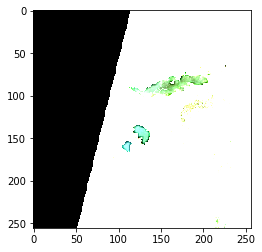

In [6]:
item = url_template.format(id=sceneid[0])

with STACReader(item) as stac:
   data, _ = stac.preview(assets=["B04", "B03", "B02"], max_size=256)

imshow(reshape_as_image(data))

### Make the data look nice

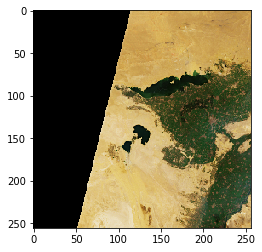

In [24]:
color_formula = "Gamma RGB 3.5 Saturation 1.7 Sigmoidal RGB 15 0.35"

data[data < 0] = 0
for ops in parse_operations(color_formula):
    data = scale_dtype(ops(to_math_type(data)), numpy.uint8)

data = data.astype(numpy.uint8)

imshow(reshape_as_image(data))

### NDVI

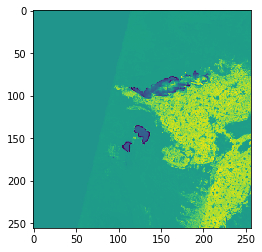

In [27]:
with STACReader(item) as stac:
   data, _ = stac.preview(expression="(B08-B04)/(B08+B04)", max_size=256)

imshow(data[0])

### Part reading

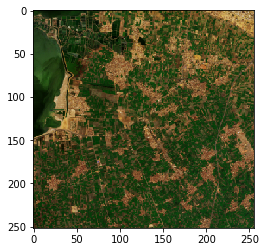

In [29]:
with STACReader(item) as stac:
   data, _ = stac.part(bounds, assets=["B04", "B03", "B02"], max_size=256)

data[data < 0] = 0
for ops in parse_operations(color_formula):
    data = scale_dtype(ops(to_math_type(data)), numpy.uint8)

data = data.astype(numpy.uint8)

imshow(reshape_as_image(data))

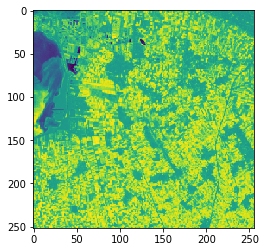

In [30]:
with STACReader(item) as stac:
   data, _ = stac.part(bounds, expression="(B08-B04)/(B08+B04)", max_size=256)

imshow(data[0])

### GET Point values

In [36]:
def _worker(sceneid):
    item = url_template.format(id=sceneid)
    lon, lat = 30.87, 29.48
    with STACReader(item) as stac:
       return stac.point(lon, lat, expression="(B08-B04)/(B08+B04)")

In [39]:
with futures.ThreadPoolExecutor(max_workers=10) as executor:
    future_work = [
        executor.submit(_worker, scene) for scene in sceneid
    ]

    for f in tqdm(futures.as_completed(future_work), total=len(future_work)):               
        pass

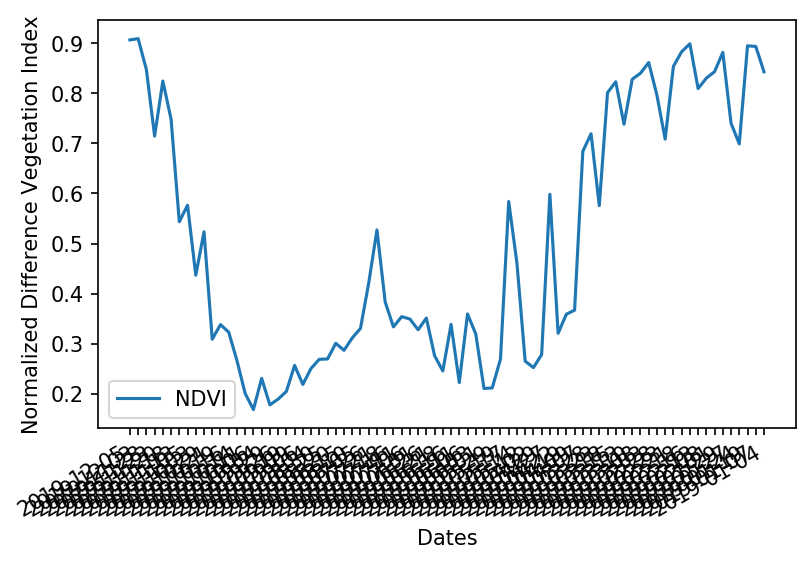

In [44]:
fig, ax1 = plt.subplots(dpi=150)
fig.autofmt_xdate()

ax1.plot(dates, [f.result()[0][0] for f in future_work], label="NDVI")

ax1.set_xlabel("Dates")
ax1.set_ylabel("Normalized Difference Vegetation Index")

ax1.legend()